In [26]:
from itertools import product
import pandas as pd
import numpy as np
import scipy.io
import os

from Rcwk.rcwk import Rcwk
from Rcwk.ckmeans import KMeansChi2
from sklearn.cluster import KMeans
from coclust.clustering.spherical_kmeans import SphericalKmeans

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import normalized_mutual_info_score,adjusted_rand_score
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import silhouette_score
from nltk.stem import WordNetLemmatizer
import re

import matplotlib.pyplot as plt
import seaborn as sns

## Import data

In [27]:
"""
tfidf 
    * CLASSIC3 | OHSCALE | CSTR | CLASSIC4  | TR45 | SPORTS
    * BBC | NG5 | NG20 
    * HM_ng20 | HM_bbc | HM_pubmed5 | HM_pubmed10 | HM_classic4
"""

data_type = 'tfidf' 
data_name = 'CSTR'

# Load dict file
mat = scipy.io.loadmat(os.path.join('new_data', data_type,data_name))

# Load labels
y = mat['labels'].flatten()
mat = mat['mat'].toarray()
k = len(set(y))

print('Shape :',mat.shape)
print('k :',k)


Shape : (475, 1000)
k : 4


#### Simple usage of RCW-kmeans

In [28]:
lamb = 0.00001    
alpha = 0   #The value 0 corresponds to the formula presented in section 4.2 Selection of Tuning Parameters
beta = 4  
scale = 0
chi2 = 1
n = 10
init = 'chi2'

res_nmi, res_ari = [],[]
silh, p2 = [],[]

for i in range(n):
    print('Iteration',i+1,'/',n,end="\r")
    rcwk = Rcwk(k, lambda_val=lamb, alpha=alpha, beta=beta, chi2=chi2, scale=scale, init = init, scaling_factor=0)#z=np.array(sk.row_labels_))
    rcwk.fit(mat, verbose=0)
    res_nmi += [normalized_mutual_info_score(rcwk.labels_,y)]
    res_ari += [adjusted_rand_score(rcwk.labels_,y)]
    
    silh.append(silhouette_score(mat, rcwk.labels_))
    p2.append(rcwk.P2)

best_nmi = [i[0] for i in sorted(zip(res_nmi, silh), key=lambda x: x[1], reverse=True)][:5]
best_ari = [i[0] for i in sorted(zip(res_ari, silh), key=lambda x: x[1], reverse=True)][:5]

best_nmi_p2 = [i[0] for i in sorted(zip(res_nmi, p2), key=lambda x: x[1], reverse=0)][:5]
best_ari_p2 = [i[0] for i in sorted(zip(res_ari, p2), key=lambda x: x[1], reverse=0)][:5]

print(f'Top 5 results Silhouette :  \nNMI: {np.mean(best_nmi):.2f} +/- {np.std(best_nmi):.2f} \nARI: {np.mean(best_ari):.2f} +/- {np.std(best_ari):.2f}')
print(f'Top 5 results P :  \nNMI: {np.mean(best_nmi_p2):.2f} +/- {np.std(best_nmi_p2):.2f} \nARI: {np.mean(best_ari_p2):.2f} +/- {np.std(best_ari_p2):.2f}')
print(f'Mean \nNMI: {np.mean(res_nmi):.2f} +/- {np.std(res_nmi):.2f} \nARI: {np.mean(res_ari):.2f} +/- {np.std(res_ari):.2f}')

Top 5 results Silhouette :  
NMI: 0.74 +/- 0.01 
ARI: 0.78 +/- 0.02
Top 5 results P :  
NMI: 0.73 +/- 0.01 
ARI: 0.78 +/- 0.02
Mean 
NMI: 0.71 +/- 0.09 
ARI: 0.75 +/- 0.11


#### Test chi-squared kmeans

In [29]:
n = 15
res_nmi, res_ari = [],[]

for i in range(n):
    print('Iteration',i+1,'/',n,end="\r")
    kmc = KMeansChi2(k=k)    
    kmc.fit(mat)
    res_nmi += [normalized_mutual_info_score(kmc.labels_,y)]
    res_ari += [adjusted_rand_score(kmc.labels_,y)]

print(f'Mean \nNMI: {np.mean(res_nmi):.2f} +/- {np.std(res_nmi):.2f} \nARI: {np.mean(res_ari):.2f} +/- {np.std(res_ari):.2f}')

Mean tion 15 / 15
NMI: 0.72 +/- 0.03 
ARI: 0.75 +/- 0.04


#### Test skmeans

In [30]:
n = 10
res_nmi, res_ari, silh = [],[],[]
for i in range(n):
    print('Iteration',i+1,'/',n,end="\r")
    sk = SphericalKmeans(n_clusters=k, n_init=20)
    sk.fit(mat)
    res_nmi += [normalized_mutual_info_score(sk.row_labels_,y)]
    res_ari += [adjusted_rand_score(sk.row_labels_,y)]

# Best mean
print(f'\nMean \nNMI: {np.mean(res_nmi):.2f} +/- {np.std(res_nmi):.2f} \nARI: {np.mean(res_ari):.2f} +/- {np.std(res_ari):.2f}')

Iteration 10 / 10
Mean 
NMI: 0.71 +/- 0.04 
ARI: 0.75 +/- 0.05


#### Test k-means

In [31]:
n = 10
res_nmi, res_ari = [],[]
for i in range(n):
    print('Iteration',i+1,'/',n,end="\r")
    mat = mat#.toarray() #mat_supp mat_tfidf.toarray()
    kmeans = KMeans(n_clusters=k, n_init=20).fit(mat)
    res_nmi += [normalized_mutual_info_score(kmeans.labels_,y)]
    res_ari += [adjusted_rand_score(kmeans.labels_,y)]

# Best mean
print(f'\nMean \nNMI: {np.mean(res_nmi):.2f} +/- {np.std(res_nmi):.2f} \nARI: {np.mean(res_ari):.2f} +/- {np.std(res_ari):.2f}')

Iteration 10 / 10
Mean 
NMI: 0.60 +/- 0.02 
ARI: 0.49 +/- 0.03


## <span style="color:Red">Analysis</span>### I. Weights

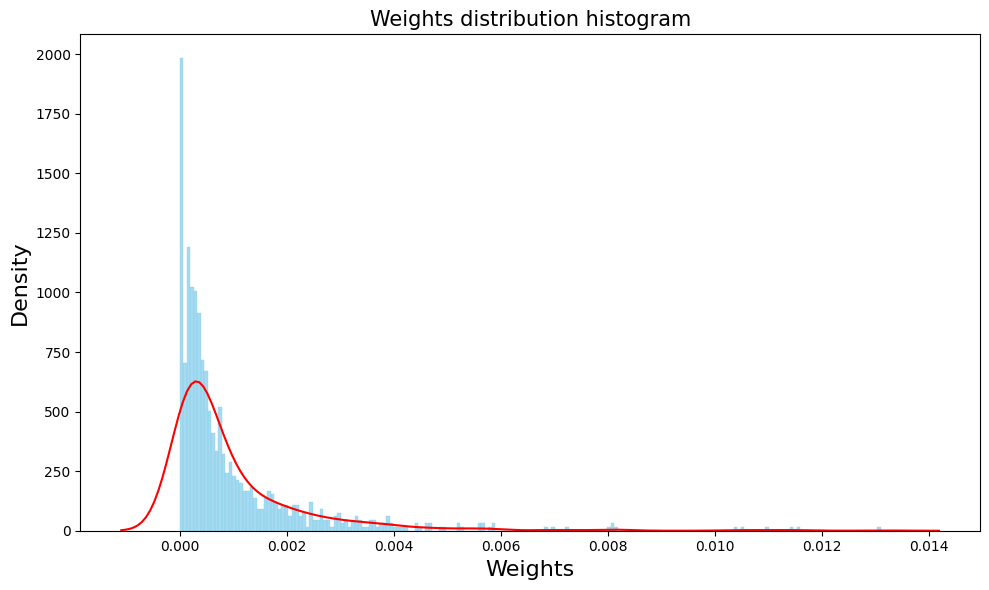

In [32]:
weights = rcwk.weights_.T
plt.figure(figsize=(10, 6))

# Histogramme
sns.histplot(weights, bins=200, kde=False, stat='density', color='skyblue', edgecolor='skyblue')
sns.kdeplot(weights, color='red')
plt.title('Weights distribution histogram', fontsize=15)
plt.xlabel('Weights', fontsize=16)
plt.ylabel('Density', fontsize=16)


# Ajustement des graphiques
plt.tight_layout()
plt.show()

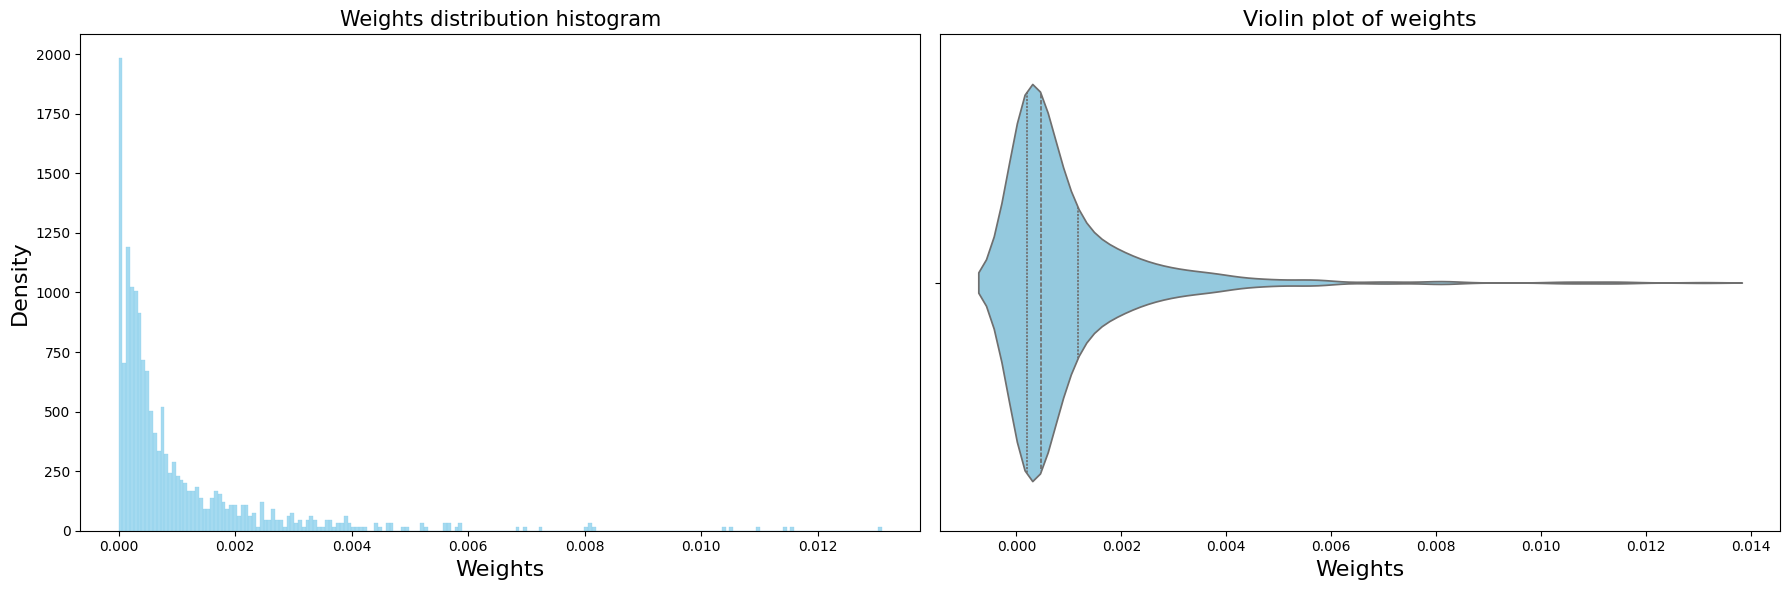

In [33]:
weights = rcwk.weights_
plt.figure(figsize=(18, 6))

# Histogramme
plt.subplot(1, 2, 1)
sns.histplot(weights, bins=200, kde=False, stat='density', color='skyblue', edgecolor='skyblue')
#sns.kdeplot(weights, color='red')
plt.title('Weights distribution histogram', fontsize=15)
plt.xlabel('Weights', fontsize=16)
plt.ylabel('Density', fontsize=16)

# Violin plot
plt.subplot(1, 2, 2)
sns.violinplot(x=weights, inner="quartile", color='skyblue')
plt.title('Violin plot of weights', fontsize=16)
plt.xlabel('Weights', fontsize=16)

plt.tight_layout()
plt.show()

### II. Top terms analysis
__Data processing and cleaning__

In [34]:
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_pattern = re.compile(
    r'\b(?:' + '|'.join(map(re.escape, ENGLISH_STOP_WORDS)) + r')\b'
)

def custom_preprocessor(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    # Remove stopwords
    text = stop_pattern.sub(' ', text)
    # lemmatisation
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens]
    return ' '.join(tokens)

In [35]:
#---- BBC News ----
# Data vectorization
data = pd.read_csv('new_data/bbc-text.csv')
vectorizer = CountVectorizer(preprocessor=custom_preprocessor,
                             min_df=5)
mat = vectorizer.fit_transform(data.text)
y = pd.Categorical(data['category']).codes
k = len(set(y))
transformer = TfidfTransformer(norm='l2')
mat_tfidf = transformer.fit_transform(mat)

__Fit rcwk__

In [36]:
n = 1
lamb = 0.0001
alpha = 0
beta = 4
scale = 0
chi2 = 1
init = 'chi2'

res_nmi, res_ari = [],[]
for i in range(n):
    print('Iteration',i+1,'/',n,end="\r")
    rcwk = Rcwk(k, lambda_val=lamb, alpha=alpha, beta=beta, chi2=chi2, scale=scale, init=init, scaling_factor=0, lambda_val_2=0.3)
    rcwk.fit(mat_tfidf.toarray(), verbose=False)
    
    res_nmi += [normalized_mutual_info_score(rcwk.labels_,y)]
    res_ari += [adjusted_rand_score(rcwk.labels_,y)]

print(f'\nNMI: {np.mean(res_nmi):.2f} +/- {np.std(res_nmi):.2f} \nARI: {np.mean(res_ari):.2f} +/- {np.std(res_ari):.2f}')

Iteration 1 / 1
NMI: 0.86 +/- 0.00 
ARI: 0.89 +/- 0.00


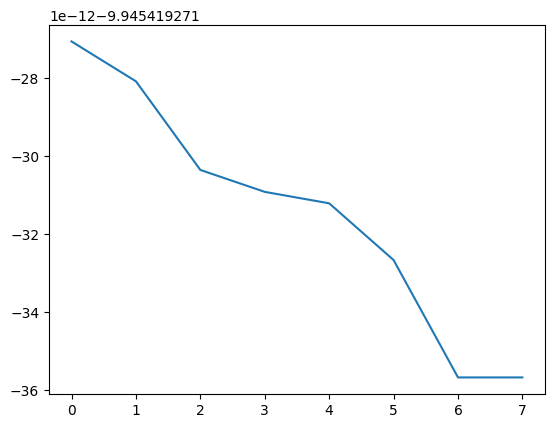

In [37]:
plt.plot(rcwk.P2_mat)

__Top terms configuration__

In [38]:
from Rcwk.top_terms_utils import get_top_terms_count, get_top_terms_weight, get_top_features

vocabulary = vectorizer.get_feature_names_out()
weights = rcwk.weights_
labels = rcwk.labels_

__Overall Top terms__

In [39]:
get_top_features(vocabulary, weights, n_features=10)

{'film': np.float64(0.011205933659745903),
 'mobile': np.float64(0.008485499761995157),
 'game': np.float64(0.006394308512685238),
 'phone': np.float64(0.006293086199503875),
 'brown': np.float64(0.005206874748043903),
 'award': np.float64(0.005185761654001618),
 'lord': np.float64(0.005181999140911989),
 'labour': np.float64(0.005150706841470217),
 'blair': np.float64(0.0050744943537964025),
 'election': np.float64(0.00492403442371601)}

__Top terms by cluster__

In [40]:
get_top_terms_weight(mat_tfidf.toarray(), labels, weights, vocabulary, max_count=500, n_features=10)

{'Cluster 0': {'game': np.float64(0.006394308512685238),
  'best': np.float64(0.004526036883560136),
  'england': np.float64(0.003390405786524279),
  'chelsea': np.float64(0.0022496229607947894),
  'wale': np.float64(0.0020989010230068484),
  'rugby': np.float64(0.0019440838689681929),
  'liverpool': np.float64(0.0017056066796092516),
  'ireland': np.float64(0.0016974737231296865),
  'cup': np.float64(0.0015025884640184144),
  'robinson': np.float64(0.0014746685837071986)},
 'Cluster 1': {'brown': np.float64(0.005206874748043903),
  'lord': np.float64(0.005181999140911989),
  'labour': np.float64(0.005150706841470217),
  'blair': np.float64(0.0050744943537964025),
  'election': np.float64(0.00492403442371601),
  'tax': np.float64(0.004221498392791306),
  'party': np.float64(0.00414817093504735),
  'mr': np.float64(0.0037467666778685047),
  'england': np.float64(0.003390405786524279),
  'tory': np.float64(0.003343677582161952)},
 'Cluster 2': {'film': np.float64(0.011205933659745903),
 